# Recalage de données 3D
# Algorithme ICP : Iterative Closest Point
## Par: Julian CAIPA.
### Pour: Computer Vision, M. ABABSA.

### Imports nécessaires

In [1]:
import numpy as np
import matplotlib.pyplot as plt
import time
import plotly.graph_objects as go
from icp_functions import ShowData, icp, MatrixComparer, Data_Generation
import open3d as o3d

Jupyter environment detected. Enabling Open3D WebVisualizer.
[Open3D INFO] WebRTC GUI backend enabled.
[Open3D INFO] WebRTCWindowSystem: HTTP handshake server disabled.


### Étape 1 : ICP simple
#### Génération des données

In [2]:
P, Q =Data_Generation()

#### Visualitation des données

In [3]:
ShowData(P, Q)

#### Récalage ICP des nuages 

In [4]:
R_opt, T_opt, E_opt, t_opt, tf_opt= icp(P, Q)

print("Optimal Rotation Matrix (R_opt):")
print(R_opt)

print("\nOptimal Translation Vector (T_opt):")
print(T_opt)

ICP completed in 27 iterations and 6.78 seconds
Optimal Rotation Matrix (R_opt):
[[ 9.99999995e-01  3.60776090e-06 -1.01512557e-04]
 [-3.60862229e-06  1.00000000e+00 -8.48537363e-06]
 [ 1.01512527e-04  8.48573991e-06  9.99999995e-01]]

Optimal Translation Vector (T_opt):
[ 0.0071674  -0.00016605  0.00175143]


#### Courbe de l’erreur de recalage

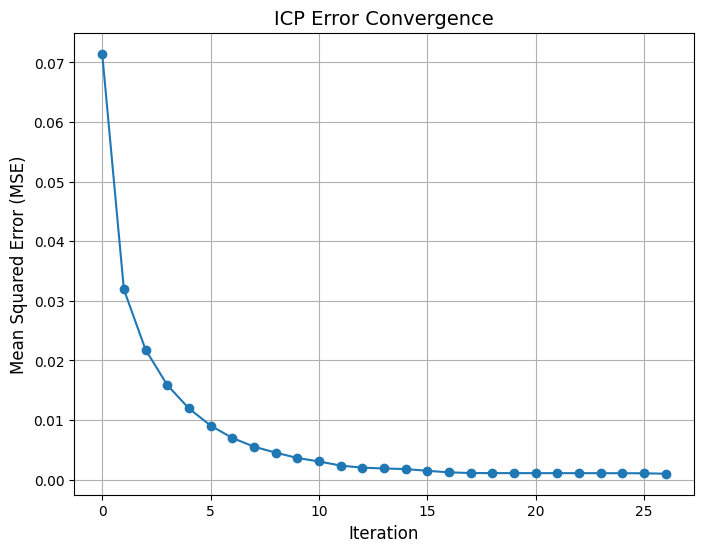

In [5]:
plt.figure(figsize=(8, 6))
plt.plot(E_opt, marker='o')
plt.xlabel("Iteration", fontsize=12)
plt.ylabel("Mean Squared Error (MSE)", fontsize=12)
plt.title("ICP Error Convergence", fontsize=14)
plt.grid(True)
plt.show()

### Étape 2 : ICP avec bruit
#### Ajout de bruit distribution gaussienne

In [6]:
noise_std = 0.01 
P_noisy = P + np.random.normal(0, noise_std, P.shape)  
Q_noisy = Q + np.random.normal(0, noise_std, Q.shape)

ShowData(P_noisy, Q_noisy)

#### Visualisation des nuages originelles et avec bruit

In [7]:
ShowData(P, P_noisy)
ShowData(Q, Q_noisy)

#### Récalage ICP des nuages avec bruit 

In [8]:
R_opt_noisy, T_opt_noisy, E_opt_noisy, t_opt_noisy, tf_opt_noisy = icp(P_noisy, Q_noisy)

print("Optimal Rotation Matrix (R_opt) with noise:")
print(R_opt_noisy)

print("\nOptimal Translation Vector (T_opt) with noise:")
print(T_opt_noisy)

ICP completed in 22 iterations and 17.50 seconds
Optimal Rotation Matrix (R_opt) with noise:
[[ 9.99997743e-01  1.96552245e-03  8.07224162e-04]
 [-1.96476484e-03  9.99997630e-01 -9.38253383e-04]
 [-8.09066407e-04  9.36665259e-04  9.99999234e-01]]

Optimal Translation Vector (T_opt) with noise:
[0.00608297 0.00089997 0.00305952]


#### Error des nuages avec bruit

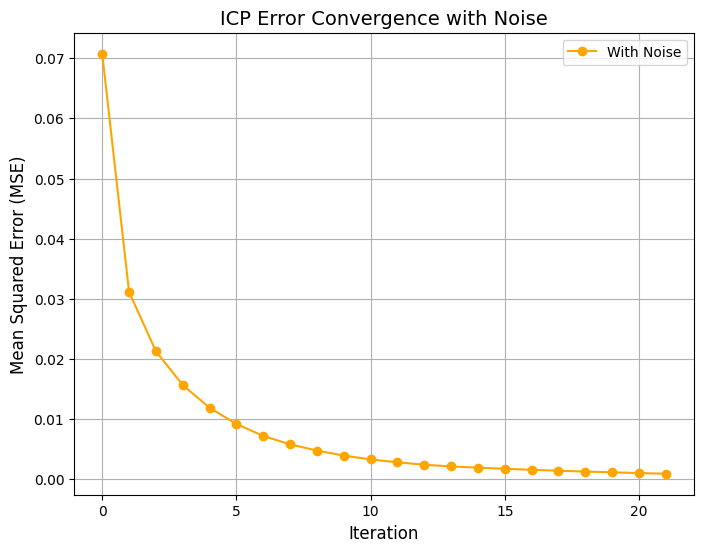

In [9]:
plt.figure(figsize=(8, 6))
plt.plot(E_opt_noisy, marker='o', label="With Noise", color="Orange")
plt.xlabel("Iteration", fontsize=12)
plt.ylabel("Mean Squared Error (MSE)", fontsize=12)
plt.title("ICP Error Convergence with Noise", fontsize=14)
plt.grid(True)
plt.legend()
plt.show()

#### Comparation des erreurs

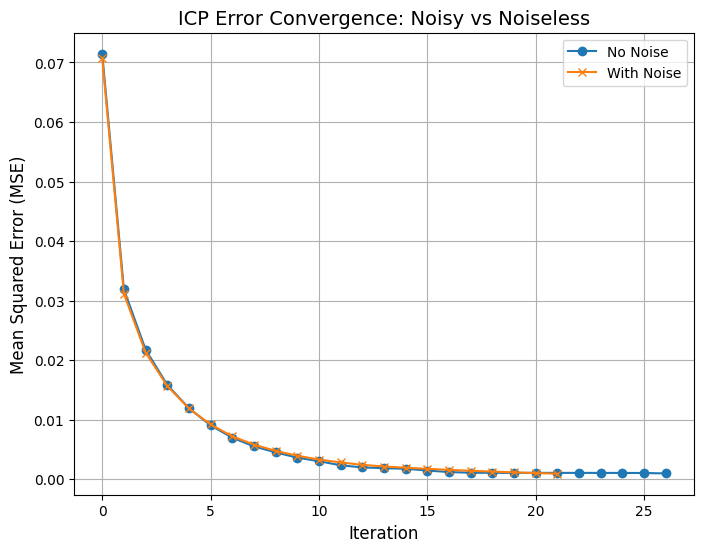

In [10]:
plt.figure(figsize=(8, 6))
plt.plot(E_opt, marker='o', label="No Noise")
plt.plot(E_opt_noisy, marker='x', label="With Noise")
plt.xlabel("Iteration", fontsize=12)
plt.ylabel("Mean Squared Error (MSE)", fontsize=12)
plt.title("ICP Error Convergence: Noisy vs Noiseless", fontsize=14)
plt.grid(True)
plt.legend()
plt.show()

#### Stats comparation 

In [11]:
MatrixComparer(R_opt,R_opt_noisy,T_opt,T_opt_noisy,tf_opt,tf_opt_noisy, E_opt[-1], E_opt_noisy[-1], "Noiseless", "Noisy")

Rotation Matrix Comparison:


Translation Vector Comparison:


Time Comparison:


Error Comparison:


### Étape 3: Autres variantes de l’algorithme ICP: Avec Open3D
#### Chargement des nuages de points

In [12]:
def numpy_to_open3d(np_points):
    pcd = o3d.geometry.PointCloud()
    pcd.points = o3d.utility.Vector3dVector(np_points)
    return pcd

P_pcd = numpy_to_open3d(P)  
Q_pcd = numpy_to_open3d(Q)  


#### Implémentation icp registration Point to point Open3D

In [13]:
max_correspondence_distance = 0.05
init_transformation = np.eye(4)

convergence_criteria = o3d.pipelines.registration.ICPConvergenceCriteria(
    relative_fitness=1e-5,
    relative_rmse=0.0316,   
    max_iteration=100       
)

start_time = time.time()
result_icp = o3d.pipelines.registration.registration_icp(
    source=P_pcd,
    target=Q_pcd,
    max_correspondence_distance=max_correspondence_distance,
    init=init_transformation,
    estimation_method=o3d.pipelines.registration.TransformationEstimationPointToPoint(),
    criteria=convergence_criteria
)
end_time = time.time()
elapsed_time = end_time - start_time

print("Transformation Matrix:")
print(result_icp.transformation)
print("\nInlier RMSE:", result_icp.inlier_rmse)
print("Fitness:", result_icp.fitness)
print(f"ICP completed in {elapsed_time:.2f} seconds")

Transformation Matrix:
[[ 9.98267919e-01  2.68056474e-02 -5.23700164e-02  2.23888810e-02]
 [-2.78819461e-02  9.99412517e-01 -1.99303516e-02 -2.30028653e-02]
 [ 5.18050040e-02  2.13560086e-02  9.98428847e-01 -6.65788858e-04]
 [ 0.00000000e+00  0.00000000e+00  0.00000000e+00  1.00000000e+00]]

Inlier RMSE: 0.03293642719375333
Fitness: 0.08015625
ICP completed in 0.07 seconds


#### Comparaison entre ICP Scratch et Open3D

In [17]:
transformation_matrix = result_icp.transformation

R_open3d = transformation_matrix[:3, :3]  
T_open3d = transformation_matrix[:3, 3]  
t_open3d=elapsed_time
E_open3d=result_icp.inlier_rmse

MatrixComparer(R_opt,R_open3d,T_opt,T_open3d,tf_opt,t_open3d, np.sqrt(E_opt[-1]), E_open3d, "Scratch","Open 3D")

Rotation Matrix Comparison:


Translation Vector Comparison:


Time Comparison:


Error Comparison:


#### Implémentation Generalized ICP Open3D

In [15]:
P_pcd.estimate_normals(search_param=o3d.geometry.KDTreeSearchParamHybrid(radius=0.1, max_nn=30))
Q_pcd.estimate_normals(search_param=o3d.geometry.KDTreeSearchParamHybrid(radius=0.1, max_nn=30))

P_pcd.estimate_covariances(search_param=o3d.geometry.KDTreeSearchParamHybrid(radius=0.1, max_nn=30))
Q_pcd.estimate_covariances(search_param=o3d.geometry.KDTreeSearchParamHybrid(radius=0.1, max_nn=30))

start_time = time.time()
result_gicp = o3d.pipelines.registration.registration_icp(
    source=P_pcd,
    target=Q_pcd,
    max_correspondence_distance=max_correspondence_distance,
    init=init_transformation,
    estimation_method=o3d.pipelines.registration.TransformationEstimationForGeneralizedICP(),
    criteria=convergence_criteria
)
end_time = time.time()
elapsed_time_gicp = end_time - start_time

print("Generalized ICP Results:")
print("Transformation Matrix:")
print(result_gicp.transformation)
print("\nInlier RMSE:", result_gicp.inlier_rmse)
print("Fitness:", result_gicp.fitness)
print(f"GICP completed in {elapsed_time_gicp:.2f} seconds")

Generalized ICP Results:
Transformation Matrix:
[[ 0.9788418  -0.0489831  -0.19866905  0.49999991]
 [-0.01089022  0.95707691 -0.2896294  -0.29999983]
 [ 0.20432851  0.28566491  0.93629345  0.1999999 ]
 [ 0.          0.          0.          1.        ]]

Inlier RMSE: 5.688812559467573e-07
Fitness: 1.0
GICP completed in 0.04 seconds


#### Comparaison entre ICP et Generalized ICP de Open3D

In [16]:
transformation_matrix = result_gicp.transformation
R_gicp = result_gicp.transformation[:3, :3] 
T_gicp = result_gicp.transformation[:3, 3]
t_gicp=elapsed_time_gicp
E_gicp=result_gicp.inlier_rmse

MatrixComparer(R_open3d,R_gicp,T_open3d,T_gicp,t_open3d, t_gicp, E_open3d,E_gicp,"ICP Point-Point", "Generalized ICP (GICP)")


Rotation Matrix Comparison:


Translation Vector Comparison:


Time Comparison:


Error Comparison:
